In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.metrics import mean_squared_error
from io import StringIO
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from collections import Counter
from statsmodels.tsa.stattools import adfuller


# Q1

## Data Import

In [10]:
# 1. Get daily data within the specified range from CryptoCompare API
def get_crypto_data(symbol, comparison_symbol='USD', start_date='2022-01-01', end_date='2024-12-31'):

    # Calculate date difference in days
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    limit = (end_dt - start_dt).days  # API returns limit+1 data points
    
    # Convert end_date to Unix timestamp as toTs parameter
    toTs = int(end_dt.timestamp())
    url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={symbol}&tsym={comparison_symbol}&limit={limit}&toTs={toTs}'
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data['Data']['Data'])
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df['close']


# 2. Get BTC and ETH closing prices from 2023 to 2024
btc_data = get_crypto_data('BTC', start_date='2023-08-01', end_date='2024-3-31')
eth_data = get_crypto_data('ETH', start_date='2023-08-01', end_date='2024-3-31')

# Convert to log prices (ensure no non-positive values)
btc_raw = np.log(btc_data.values)
eth_raw = np.log(eth_data.values)


## Raw data visualisation

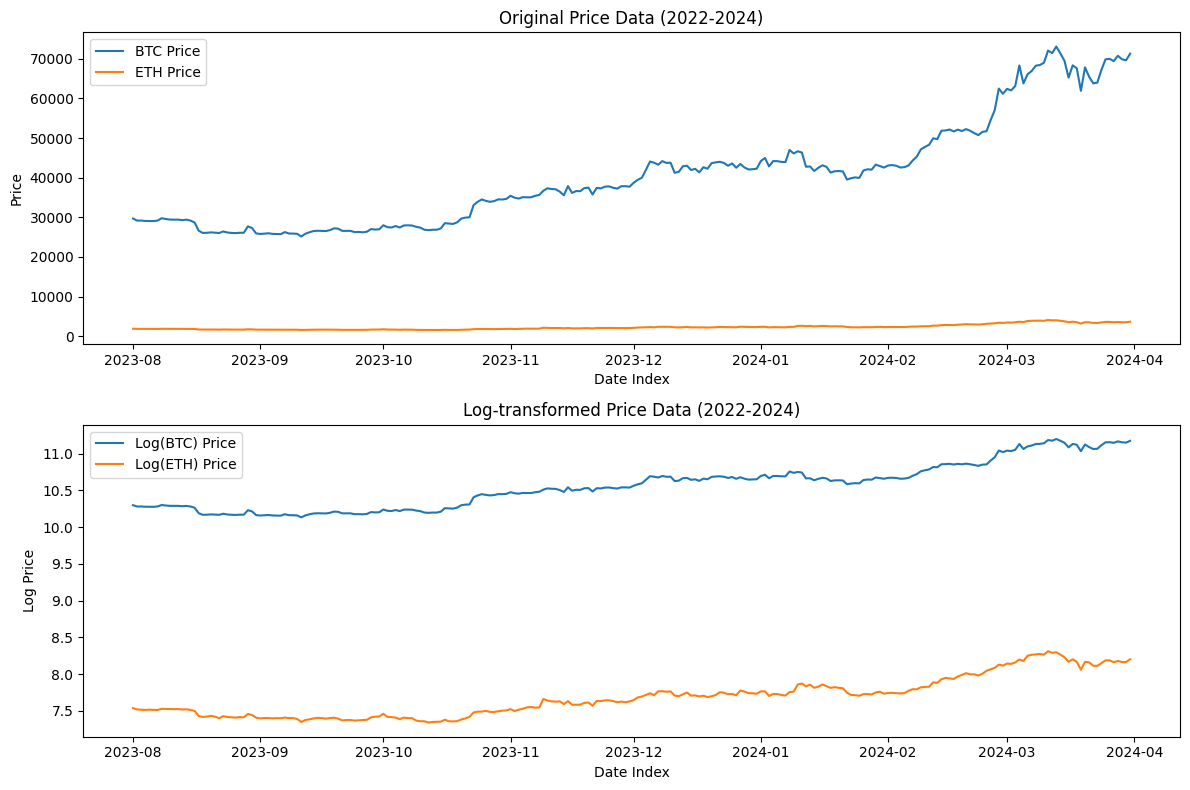

In [3]:
# 3. Apply log transformation to the raw data
btc_log = np.log(btc_data)
eth_log = np.log(eth_data)

# Plot original and log-transformed price data (titles in English)
plt.figure(figsize=(12, 8))

# Plot original price data
plt.subplot(2, 1, 1)
plt.plot(btc_data, label='BTC Price')
plt.plot(eth_data, label='ETH Price')
plt.title('Original Price Data (2022-2024)')
plt.xlabel('Date Index')
plt.ylabel('Price')
plt.legend()

# Plot log-transformed price data
plt.subplot(2, 1, 2)
plt.plot(btc_log, label='Log(BTC) Price')
plt.plot(eth_log, label='Log(ETH) Price')
plt.title('Log-transformed Price Data (2022-2024)')
plt.xlabel('Date Index')
plt.ylabel('Log Price')
plt.legend()

plt.tight_layout()
plt.show()


## Function Construction

### Numpy

In [4]:
# Construct the design matrix: first column is the intercept, second is log(BTC) price
X = np.vstack([np.ones(len(btc_log)), btc_log.values.flatten()]).T
Y = eth_log.values.flatten()

# NumPy least squares solution
beta_np = np.linalg.lstsq(X, Y, rcond=None)[0]

# Print the results
print("\n[NumPy Linear Algebra Solution] (Log Prices)")
print(f"Intercept (α): {beta_np[0]}")
print(f"Slope (β): {beta_np[1]}")



[NumPy Linear Algebra Solution] (Log Prices)
Intercept (α): -1.2645540928324364
Slope (β): 0.8474372248304897


### Gradient Descent


Running gradient descent on log-transformed price data:
Iteration 0, Cost: 0.49795081967213123
Gradient descent converged after 57 iterations.
Gradient descent (standardized log prices) parameters: [-1.12614835e-16  9.77107728e-01]


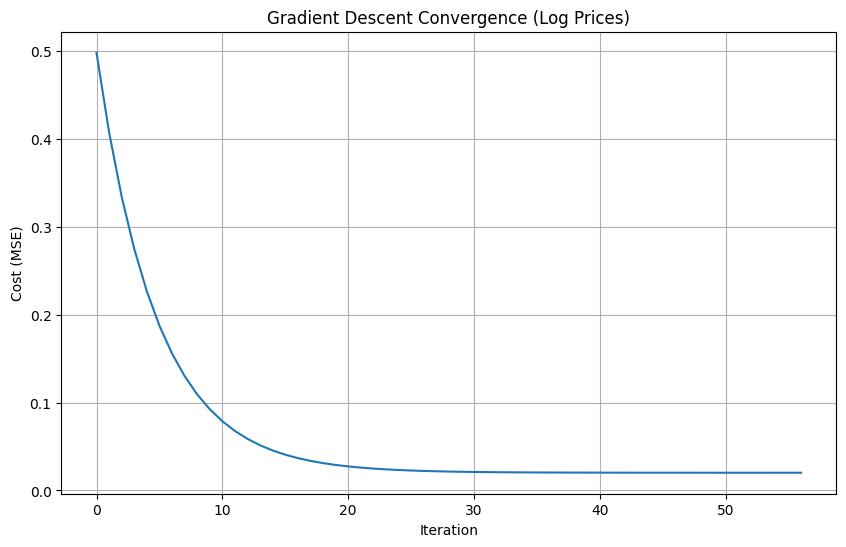


[Gradient Descent (Restored Log Scale)]
Intercept (α): -1.2419174923951832
Slope (β): 0.8452933438066337


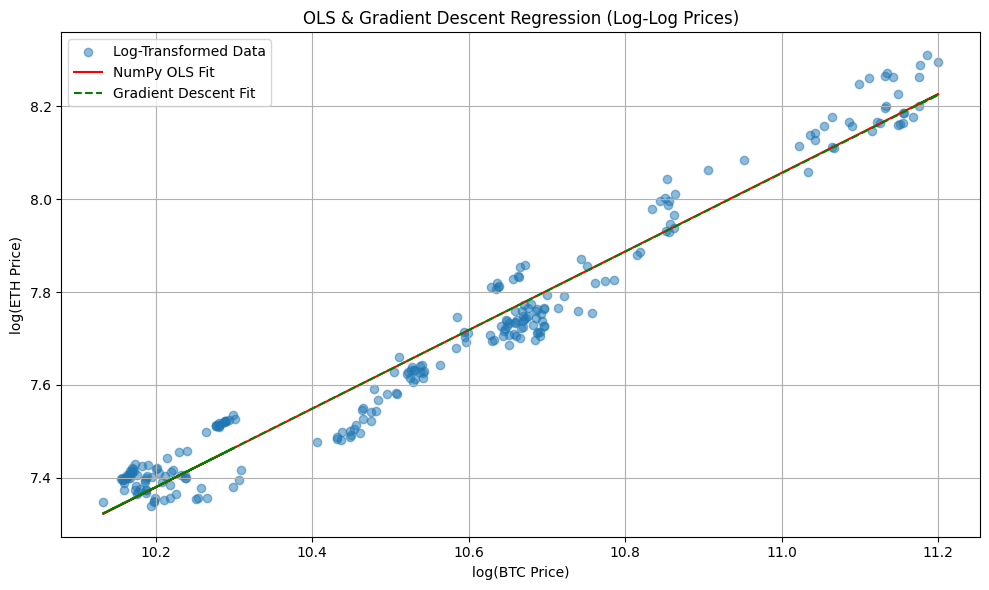

In [5]:
# --- OLS Gradient Descent (Log Prices) ---
def gradient_descent(x, y, learning_rate=0.01, iterations=2000, tolerance=1e-6):
    """
    Solve the least squares problem using gradient descent (log prices).
    """
    # Construct the design matrix (add intercept)
    X = np.vstack([np.ones(len(x)), x]).T
    theta = np.zeros(2)  # Initialize parameters [α, β]
    m = len(y)
    cost_history = []
    prev_cost = float('inf')
    
    for i in range(iterations):
        predictions = X.dot(theta)
        error = predictions - y
        gradients = (1/m) * X.T.dot(error)
        theta = theta - learning_rate * gradients
        cost = (1/(2*m)) * np.sum(error**2)
        cost_history.append(cost)
        
        if abs(prev_cost - cost) < tolerance:
            print(f"Gradient descent converged after {i+1} iterations.")
            break
        
        prev_cost = cost
        if i % 100 == 0:
            print(f"Iteration {i}, Cost: {cost}")
    
    return theta, cost_history

# Standardize log-transformed data
btc_scaled = (btc_log - btc_log.mean()) / btc_log.std()
eth_scaled = (eth_log - eth_log.mean()) / eth_log.std()

print("\nRunning gradient descent on log-transformed price data:")
theta_gd, cost_history = gradient_descent(btc_scaled.values.flatten(), eth_scaled.values.flatten(), learning_rate=0.1, iterations=2000)
print("Gradient descent (standardized log prices) parameters:", theta_gd)

# Visualize the loss convergence process
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Gradient Descent Convergence (Log Prices)')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.grid(True)
plt.show()

# Convert standardized coefficients back to original log scale (used in log-log regression line)
alpha_scaled, beta_scaled = theta_gd
btc_mean, btc_std = btc_log.mean(), btc_log.std()
eth_mean, eth_std = eth_log.mean(), eth_log.std()

beta_orig = beta_scaled * (eth_std / btc_std)
alpha_orig = alpha_scaled * eth_std + eth_mean - beta_orig * btc_mean

print("\n[Gradient Descent (Restored Log Scale)]")
print(f"Intercept (α): {alpha_orig}")
print(f"Slope (β): {beta_orig}")

# ---------------------------
# Plot the regression lines from OLS and gradient descent (log-log model)
# ---------------------------
plt.figure(figsize=(10, 6))
plt.scatter(btc_log, eth_log, alpha=0.5, label='Log-Transformed Data')

# NumPy OLS fitted line (already computed as beta_np, log-log)
plt.plot(btc_log, beta_np[0] + beta_np[1] * btc_log, 'r', label='NumPy OLS Fit')

# Gradient descent fitted line
plt.plot(btc_log, alpha_orig + beta_orig * btc_log, 'g--', label='Gradient Descent Fit')

plt.xlabel('log(BTC Price)')
plt.ylabel('log(ETH Price)')
plt.title('OLS & Gradient Descent Regression (Log-Log Prices)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Model Evaluation

In [6]:
# Construct the design matrix (add constant), using log(BTC) as independent variable
X_sm = sm.add_constant(btc_log.values)  # log(BTC)
Y_sm = eth_log.values                   # log(ETH)

# Fit the OLS model with White heteroskedasticity-robust standard errors
model = sm.OLS(Y_sm, X_sm).fit(cov_type='HC0')

print("\n[Statsmodels OLS with Heteroskedasticity-Robust SE (White's, Log-Log)]")
print(model.summary())

# Use raw (non-robust) residuals for Breusch-Pagan heteroskedasticity test
model_nonrobust = sm.OLS(Y_sm, X_sm).fit()
residuals = model_nonrobust.resid
bp_test = het_breuschpagan(residuals, X_sm)

# Print BP test results
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("\n[Breusch-Pagan Test for Heteroskedasticity (Log-Log)]")
for name, value in zip(labels, bp_test):
    print(f"{name}: {value:.4f}")



[Statsmodels OLS with Heteroskedasticity-Robust SE (White's, Log-Log)]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     5990.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):          1.02e-172
Time:                        21:58:35   Log-Likelihood:                 368.29
No. Observations:                 244   AIC:                            -732.6
Df Residuals:                     242   BIC:                            -725.6
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

# Q2

## Data Import

In [7]:
# Download cryptocurrency data
def get_crypto_data(ticker, start_date, end_date):
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        if df.empty:
            print(f"Failed to download or no data for {ticker}")
        else:
            print(f"Successfully downloaded {ticker} data")
        return df
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return pd.DataFrame()

# Flatten column names
def flatten_columns(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0].replace(' ', '_') for col in df.columns.values]
    df.columns = [f"{ticker}_{col}" for col in df.columns]
    return df

# Construct features + reduce to core variables
def create_features(main_ticker, external_tickers, start_date, end_date):
    main_df = get_crypto_data(main_ticker, start_date, end_date)
    if main_df.empty:
        return pd.DataFrame()

    main_df = flatten_columns(main_df, main_ticker)
    df = main_df.copy()

    price_col = f"{main_ticker}_Close"
    volume_col = f"{main_ticker}_Volume"
    open_col = f"{main_ticker}_Open"
    high_col = f"{main_ticker}_High"
    low_col = f"{main_ticker}_Low"

    df['price'] = df[price_col]
    df['return'] = df['price'].pct_change()

    for lag in [1, 2, 3, 5, 7, 14, 30]:
        df[f'return_lag_{lag}'] = df['return'].shift(lag)

    for w in [5, 10, 20, 100]:
        df[f'SMA_{w}'] = df['price'].rolling(window=w).mean()
    df['SMA_200'] = df['price'].rolling(window=200).mean()

    df['SMA_5_diff'] = (df['price'] - df['SMA_5']) / df['SMA_5']
    df['SMA_20_diff'] = (df['price'] - df['SMA_20']) / df['SMA_20']

    for w in [5, 10, 20]:
        df[f'volatility_{w}'] = df['return'].rolling(window=w).std()

    df['volume_change'] = df[volume_col].pct_change()
    df['volume_SMA_5'] = df[volume_col].rolling(window=5).mean()
    df['volume_ratio'] = df[volume_col] / df['volume_SMA_5']
    df['high_low_ratio'] = df[high_col] / df[low_col]
    df['close_open_ratio'] = df[price_col] / df[open_col]

    df['price_up'] = (df[price_col] > df[open_col]).astype(int)
    for lag in [1, 2, 3]:
        df[f'price_up_lag_{lag}'] = df['price_up'].shift(lag)

    delta = df['price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    ema12 = df['price'].ewm(span=12, adjust=False).mean()
    ema26 = df['price'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26

    # Load external cryptocurrency features
    for ticker in external_tickers:
        ext_df = get_crypto_data(ticker, start_date, end_date)
        if ext_df.empty:
            continue
        ext_df = flatten_columns(ext_df[["Close"]], ticker)
        df = df.join(ext_df, how='inner')

    df['target'] = df['price'].pct_change(periods=5).shift(-5)
    df.dropna(inplace=True)

    # Feature reduction: keep core technical indicators + external coin close prices + target
    selected_features = [
        'price', 'return', 'SMA_5', 'SMA_20', 'SMA_5_diff', 'SMA_20_diff',
        'volatility_5', 'volatility_20', 'volume_change', 'volume_ratio',
        'high_low_ratio', 'close_open_ratio', 'RSI', 'MACD'
    ]
    for ticker in external_tickers:
        selected_features.append(f"{ticker}_Close")
    selected_features.append('target')

    df = df[selected_features]
    return df

# Call function: use Bitcoin and crypto-related indices
main_ticker = 'BTC-USD'
external_tickers = ['ETH-USD', 'BNB-USD', 'SOL-USD', 'DOGE-USD']
#external_tickers = ['ETH-USD', 'BNB-USD',  'DOGE-USD']
start_date = '2015-01-01'
end_date = '2025-04-20'

df = create_features(main_ticker, external_tickers, start_date, end_date)

if not df.empty:
    print("Feature extraction succeeded!")
    print(df.head())
    print("Feature columns:", df.columns.tolist())
    print("Data shape:", df.shape)
else:
    print("Data processing failed!")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded BTC-USD data


[*********************100%***********************]  1 of 1 completed


Successfully downloaded ETH-USD data
Successfully downloaded BNB-USD data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded SOL-USD data
Successfully downloaded DOGE-USD data
Feature extraction succeeded!
                  price    return        SMA_5       SMA_20  SMA_5_diff  \
Date                                                                      
2020-04-10  6865.493164 -0.059791  7189.975391  6681.186011   -0.045130   
2020-04-11  6859.083008 -0.000934  7107.435742  6732.627417   -0.034943   
2020-04-12  6971.091797  0.016330  7066.371191  6760.366260   -0.013483   
2020-04-13  6845.037598 -0.018082  6968.558984  6765.877954   -0.017726   
2020-04-14  6842.427734 -0.000381  6876.626660  6773.946191   -0.004973   

            SMA_20_diff  volatility_5  volatility_20  volume_change  \
Date                                                                  
2020-04-10     0.027586      0.047985       0.045361       0.252985   
2020-04-11     0.018783      0.030072       0.042887      -0.284272   
2020-04-12     0.031171      0.032407       0.037185       0.145329   
2020-04-13    

## Stationarity Test and Differencing

In [8]:
def check_stationarity_and_diff(df, exclude_cols=None, max_diff=2):
    if exclude_cols is None:
        exclude_cols = []

    result = {}
    diffed_df = df.copy()

    for col in df.columns:
        if col in exclude_cols:
            continue

        series = df[col].dropna()
        d = 0
        p_value = 1.0

        while d <= max_diff:
            try:
                adf_test = adfuller(series)
                p_value = adf_test[1]
            except:
                p_value = 1.0
            if p_value < 0.05:
                break
            series = series.diff().dropna()
            d += 1

        result[col] = {'p_value': round(p_value, 4), 'diff_order': d}

        if d > 0:
            diffed_series = df[col]
            for _ in range(d):
                diffed_series = diffed_series.diff()
            diffed_df[col] = diffed_series

    diffed_df.dropna(inplace=True)
    result_summary = pd.DataFrame(result).T.sort_values(by='diff_order', ascending=False)

    print("Stationarity test and differencing summary:")
    print(result_summary)

    print("\nShape after differencing:", diffed_df.shape)
    print("\nPreview of data after differencing:")
    print(diffed_df.head())

    return result_summary, diffed_df

# Perform stationarity test using Bitcoin feature data
result_summary, df_diffed = check_stationarity_and_diff(df, exclude_cols=['target'])


Stationarity test and differencing summary:
                  p_value  diff_order
price              0.0000         1.0
SMA_5              0.0000         1.0
ETH-USD_Close      0.0000         1.0
SMA_20             0.0000         1.0
SOL-USD_Close      0.0000         1.0
BNB-USD_Close      0.0000         1.0
return             0.0000         0.0
volatility_5       0.0000         0.0
SMA_5_diff         0.0000         0.0
SMA_20_diff        0.0000         0.0
volume_ratio       0.0000         0.0
volume_change      0.0000         0.0
volatility_20      0.0007         0.0
high_low_ratio     0.0000         0.0
MACD               0.0000         0.0
RSI                0.0000         0.0
close_open_ratio   0.0000         0.0
DOGE-USD_Close     0.0203         0.0

Shape after differencing: (1830, 19)

Preview of data after differencing:
                 price    return      SMA_5     SMA_20  SMA_5_diff  \
Date                                                                 
2020-04-11   -6.410

## Main Function

Data time range: 2020-04-10 00:00:00 → 2025-04-14 00:00:00
2025-01-01 → l1_ratio = 0.900, alpha = 468304.8625
2025-01-02 → l1_ratio = 0.900, alpha = 468304.8625
2025-01-03 → l1_ratio = 0.900, alpha = 470164.0421
2025-01-04 → l1_ratio = 0.900, alpha = 472098.0063
2025-01-05 → l1_ratio = 0.900, alpha = 474075.1013
2025-01-06 → l1_ratio = 0.900, alpha = 476087.9910
2025-01-07 → l1_ratio = 0.900, alpha = 478301.3926
2025-01-08 → l1_ratio = 0.900, alpha = 480309.3199
2025-01-09 → l1_ratio = 0.900, alpha = 482217.0594
2025-01-10 → l1_ratio = 0.900, alpha = 483981.9207
2025-01-11 → l1_ratio = 0.900, alpha = 485799.6965
2025-01-12 → l1_ratio = 0.900, alpha = 487553.9450
2025-01-13 → l1_ratio = 0.900, alpha = 489283.5547
2025-01-14 → l1_ratio = 0.900, alpha = 491006.0932
2025-01-15 → l1_ratio = 0.900, alpha = 492826.2898
2025-01-16 → l1_ratio = 0.900, alpha = 494831.2924
2025-01-17 → l1_ratio = 0.900, alpha = 496844.3977
2025-01-18 → l1_ratio = 0.900, alpha = 499112.4506
2025-01-19 → l1_ratio =

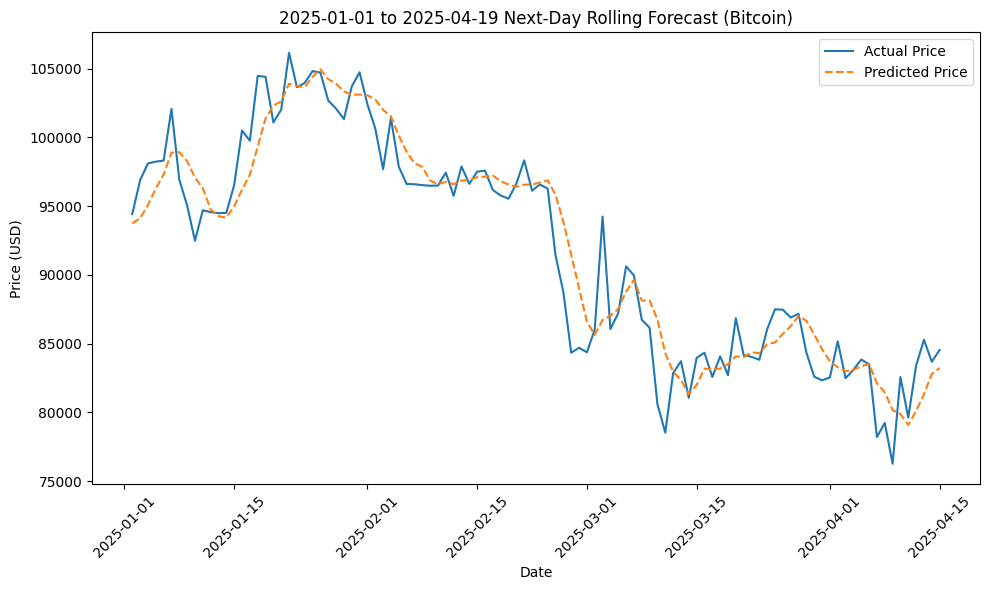


 Model Evaluation:
R²  = 0.9105
MAE = 1733.9086
MSE = 5619815.3910


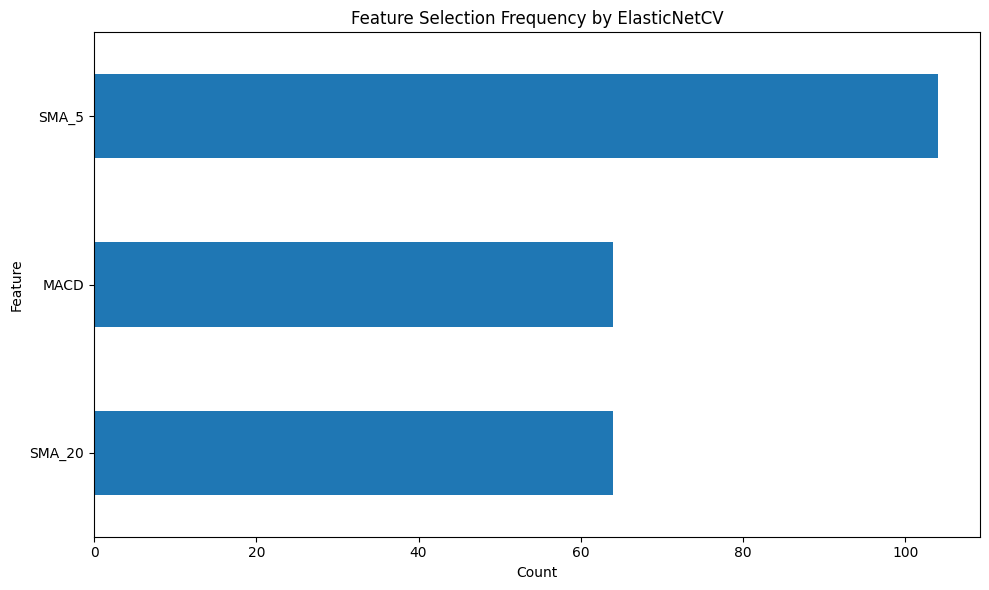

In [9]:
# Check the time range of df to confirm forecast window is valid
print("Data time range:", df.index.min(), "→", df.index.max())

# 1. Prepare modeling data
df_model = df.dropna().copy()
X = df_model.drop(columns=['price', 'target'])  # target is not used in prediction
y = df_model['price']

#print("\nFeatures used in the model:")
#print(X.columns.tolist())

# 2. Set training & forecasting window
train_end      = '2025-01-01'
forecast_start = '2025-01-01'
forecast_end   = '2025-04-19'  # Because we're predicting the next day, shift by one

X_train   = X.loc[:train_end]
y_train   = y.loc[:train_end]
X_fore    = X.loc[forecast_start:forecast_end]
y_actual  = y.loc[forecast_start:forecast_end]

if X_fore.empty or y_actual.empty:
    print(" No data in the forecast window, please check forecast_start and forecast_end!")
else:
    # 3. Initialize model
    tscv = TimeSeriesSplit(n_splits=5)
    enet_cv = ElasticNetCV(
        l1_ratio=[0.1, 0.5, 0.9],
        alphas=None,
        cv=tscv,
        max_iter=5000
    )

    y_pred = pd.Series(dtype=float)
    hist_X = X_train.copy()
    hist_y = y_train.copy()

    feature_log = {}  # Used to record features selected each day

    for date in X_fore.index:
        enet_cv.fit(hist_X, hist_y)
        print(f"{date.date()} → l1_ratio = {enet_cv.l1_ratio_:.3f}, alpha = {enet_cv.alpha_:.4f}")

        y_hat = enet_cv.predict(X_fore.loc[[date]])[0]
        next_day = date + pd.Timedelta(days=1)
        y_pred.loc[next_day] = y_hat  # Place the prediction result on the "next day"

        # Record non-zero coefficient features
        coefs = pd.Series(enet_cv.coef_, index=X.columns)
        nonzero = coefs[coefs != 0].sort_values(key=abs, ascending=False)
        feature_log[next_day.date()] = list(nonzero.index)

        # Update training set
        hist_X.loc[date] = X_fore.loc[date]
        hist_y.loc[date] = y_actual.loc[date]

    # Align actual values to next day
    y_actual_shifted = y_actual.copy()
    y_actual_shifted.index = y_actual_shifted.index + pd.Timedelta(days=1)

    # 4. Visualize prediction results
    combined = pd.concat([y_actual_shifted, y_pred], axis=1).dropna()
    combined.columns = ['Actual Price', 'Predicted Price']

    plt.figure(figsize=(10,6))
    plt.plot(combined.index, combined['Actual Price'], label='Actual Price')
    plt.plot(combined.index, combined['Predicted Price'], label='Predicted Price', linestyle='--')
    plt.title(f'{forecast_start} to {forecast_end} Next-Day Rolling Forecast (Bitcoin)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 5. Model evaluation
    if len(combined) >= 2:
        r2  = r2_score(combined['Actual Price'], combined['Predicted Price'])
        mae = mean_absolute_error(combined['Actual Price'], combined['Predicted Price'])
        mse = mean_squared_error(combined['Actual Price'], combined['Predicted Price'])

        print(f"\n Model Evaluation:")
        print(f"R²  = {r2:.4f}")
        print(f"MAE = {mae:.4f}")
        print(f"MSE = {mse:.4f}")
    else:
        print(" Not enough valid samples for model evaluation.")

    # 6. Visualize feature selection frequency
    all_features = []
    for day_feats in feature_log.values():
        all_features.extend(day_feats)
    
    feature_counts = Counter(all_features)

    plt.figure(figsize=(10,6))
    pd.Series(feature_counts).sort_values().plot(kind='barh')
    plt.title("Feature Selection Frequency by ElasticNetCV")
    plt.xlabel("Count")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
